In [22]:
import pickle # used to dump (read) list to (from) folder
import pandas as pd
import matplotlib.pylab as plt
import networkx as nx           # `pip install networkx`
import json
from collections import Counter
import community                # `pip install python-louvain` or `conda install -c auto python-louvain`
from tqdm import tqdm
import matplotlib.pyplot as plt
from publib import set_style, fix_style
from scipy.stats import norm
import numpy as np
from netwulf import visualize

# Part 1: Network null models

Ex. 10.1.1: 

Say you want to assess whether the diameter of your network is significantly larger than a random network. You could
then apply the same approach as with the triangles - create 1000 random networks by shuffling the links of the nodes
and calculating the longest shortest path (the diameter) of each of these networks. You could then calculate the fraction
of the 1000 instances where the diameter of your network's diameter was longer than the diameter of the random network.


Ex. 10.1.2:

It simply swaps links/edges randomly without changing the node degrees. It only swaps, if the new link does not already exist. In that way, the algorithm will keep on trying new random swaps until it finds a solution, where all nodes keep the same number of edges.

You could imagine a situation, where it is not possible to do a swap without changing the degree of some nodes. In this case the swap will not be performed. The max_tries specifies how many attempts to perform before 'giving up'.

Ex. 10.1.3:

In [23]:
# load data:
data = pd.read_csv(
    "/Users/karlbindslev/Documents/Studie/SDS_Econometrics_ML/Exercises/Exercise_9/facebook-wall.txt",
    delimiter="\t",
    header=None,
    names=['user1', 'user2', 'timestamp']
)


# Count the number of times each link occurs and store that in a new 'weight' column
data2 = data.groupby(['user1', 'user2']).size().reset_index(name='weight')

# Create a `nx.Graph` from this dataframe
G = nx.from_pandas_edgelist(data2, 'user1', 'user2', 'weight', create_using=nx.Graph)

G.number_of_edges() # 193.494
G.number_of_nodes() #  46.952

46952

In [24]:
# 1) Measuring the average local clustering coefficient (ALCC) of G and printing it:

alcc_G = nx.average_clustering(G)
print('The Average Local Clustering Coefficient (ALCC) is: {}'.format(round(alcc_G,3)))

The Average Local Clustering Coefficient (ALCC) is: 0.108


In [25]:
# 2) Measuring ALCC for G in 1.000 iterations with 1.000 edge swaps in each iteration:

alcc_ls = []

'''
for _ in tqdm(range(1000)):
    G_ = G.copy()
    G_ = nx.double_edge_swap(G_, nswap=1000, max_tries=5000, seed=None)
    alcc_ = nx.average_clustering(G_)
    alcc_ls.append(alcc_)

with open("Exercises/Exercise_10/alcc_ls.txt", "wb") as fp:   #Pickling
    pickle.dump(alcc_ls, fp)
'''

with open("/Users/karlbindslev/Documents/Studie/SDS_Econometrics_ML/Exercises/Exercise_10/alcc_ls.txt", "rb") as fp:   # Unpickling
    alcc_ls = pickle.load(fp)

print('The mean ALCC is: {}'.format(round(np.mean(alcc_ls),3)))

The mean ALCC is: 0.105


In [26]:
# 3) Reporting the p-value:

p_value = sum([i >= alcc_G for i in alcc_ls])/len(alcc_ls)
print('The p-value is {}'.format(p_value))

The p-value is 0.0


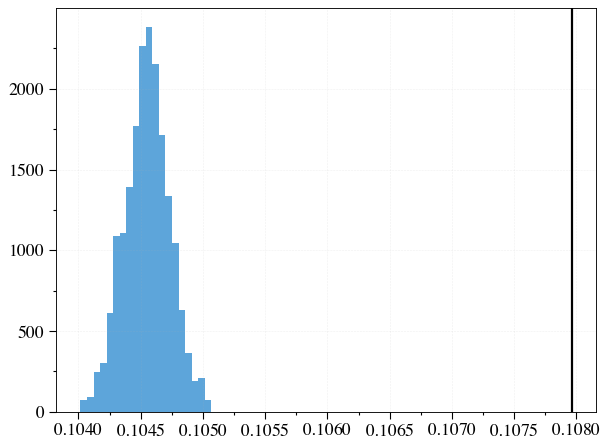

In [27]:
# 4) Making a histogram:

# using the stylesheet publib
set_style('article')

fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(alcc_ls, bins=20, density=True)
# plot vertical line:
ax.axvline(alcc_G, color='black')

fix_style('article')

From the p_value and the plot it is quite obvious, that the clustering coefficient in the facebook network is larger than the random ones, we generated with the double_edge_swap. This makes good sense, since we would expect users to tend to cluster with their friends and not just interact completely random.

# Part 2: Community Detection

### The modularity function

Ex. 10.2.1:

1) i is a node (the algorithm loops through all nodes) and j is a neighbor of i.

2) We could implement this as an if-statement checking whether the communities of the nodes i and j are the same, e.g.: if c_i == c_j: delta = 1 else: delta = 0. In the modularity function this is used to neglect the sum if the nodes are not in the same community. Thus the value of Q is only affected by the relation between nodes in the same cluster.

3) The null model is the probability that i and j are connected, if the network was unweighted, i.e. if all nodes had the same number of links. The numerator is the number of possible links between i and j (the number of links of i multiplied by the number of links of j). The denominator is the number of links (m) times 2, which is approximately the total number of possible links. In this case we use the weight of i and j - I guess we could also use the average weights or randomize the weights?

4) We're interested in a measure of how much the nodes we have put in the same cluster are related. So we only add the "more than random" degree of connection between nodes from the same cluster.

5) This term scales the "more than random" degree of connection with the total number of possible connections. This is due to the fact that 1 link/connection above the random/expected is a lot, if the network is not very connected but not that significant, if the network is very connected.

6) The modularity function measures to what extend nodes from the same clusters connect more than they would at random. The measure is scaled by the degree of connectivity of the network, so it can be compared between different networks? If the value of Q is high, it indicates that the nodes connect to a high degree with nodes from their own cluster, which is a sign, that the clustering is somewhat good.


Ex. 10.2.2:

In [28]:
A = np.array([
    [0, 1, 1, 0, 0, 0],
    [1, 0, 1, 0, 0, 0],
    [1, 1, 0, 1, 0, 0],
    [0, 0, 1, 0, 1, 1],
    [0, 0, 0, 1, 0, 1],
    [0, 0, 0, 1, 1, 0],
])

c = [0, 0, 0, 0, 1, 1]

def modularity(A, c):
    """Compute modularity for a labeled network.
    Input
    -----
        A : numpy.array
            Adjacency matrix. (N, N) square matrix.
        c : list of ints
            Community labels. Length N.
    Output
    ------
        out : float
    """
    
    Q = 0
    for i in range(0, A.shape[0]):

        for j in range(0, A.shape[1]):
            
            delta_ = c[i] == c[j]
            k_i = sum(A[i])
            k_j = sum(A[j])
            m = A.sum()/2
            Q += (A[i][j] - (k_i*k_j)/(2*m))*delta_

    return Q/(2*m)

print('Modularity score: {}'.format(round(modularity(A,c), 3))) # 0.122

Modularity score: 0.122


Ex. 10.2.3: 

Modularity score for new labeling: 0.357


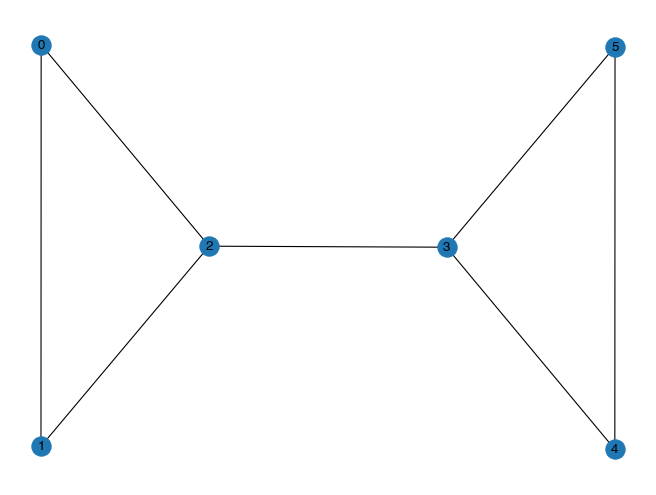

In [29]:
# Creating a graph from the numpy matrix A:
G_A = nx.from_numpy_matrix(A, create_using=nx.Graph)
# drawing the graph:
nx.draw(G_A, with_labels=True)
# the drawing suggests the following new labeling:
c_new = [0,0,0,1,1,1]

print('Modularity score for new labeling: {}'.format(round(modularity(A,c_new), 3))) # 0.357

Thus the new labeling is way better.

### Finding the best communities

Ex. 10.2.BONUS:

In [30]:
### 1) Set every node to be its own community (initiate c = [0, 1, 2, 3, 4, 5]).
c_louvain = [0,1,2,3,4,5]
c_ = [0,1,2,3,4,5]
### 2) Compute the modularity.
modularity(A,c_louvain)

no_increase_tries = 0
while no_increase_tries < 20:

    ### 3) Now pick a random node.
    random_node = np.random.randint(0, len(c_louvain))

    ## A) For every neighbor it has, try giving it the neighbor's label, and compute the change in modularity.
    neighbors = np.where(A[random_node] == 1)[0]
    # creating variable to measure improvement
    c_louvain_old = c_louvain.copy()

    for neighbor in neighbors:
        c_ = c_louvain.copy()
        c_[random_node] = c_louvain[neighbor]

        if modularity(A, c_) > modularity(A,c_louvain):
            c_louvain = c_.copy()

    if c_louvain_old >= c_louvain:
        no_increase_tries += 1
        
print(c_louvain)

[0, 0, 0, 5, 5, 5]


The clustering is right - the first 3 nodes in one cluster and the last 3 in a second cluster.

### Communication communities on Facebook

Ex. 10.2.4:

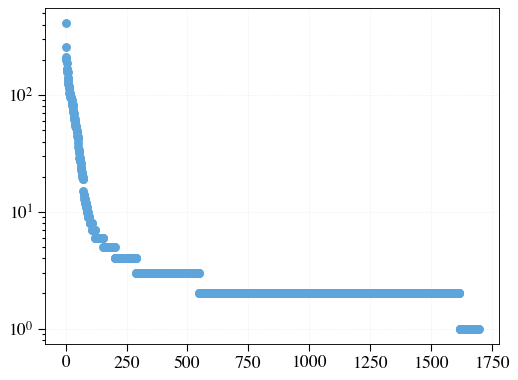

In [31]:
# we'll only use a subset of the dataset - last 365 days
t0 = data.timestamp.max() - 86400 * 365  # Lower bound of time-slice (here: 365 days before last wall post)
t1 = data.timestamp.max()              # Upper bound of time-slice

def slicer_thr(t0, t1, thr=5):
    # Subset of the pandas dataframe
    data_t = data.loc[data.timestamp.between(t0, t1)]

    # Count the number of times each link occurs and store that in a new 'weight' column
    data_t = data_t.groupby(['user1', 'user2']).size().reset_index(name='weight')

    # apply threshold - only link weight over thr
    data_t = data_t.loc[data_t.weight > thr]

    # Create a `nx.Graph` from this dataframe
    return nx.from_pandas_edgelist(data_t, 'user1', 'user2', 'weight', create_using=nx.Graph) # Undirected graph

G_thr = slicer_thr(t0, t1, thr=5)
G_thr.number_of_edges() # 14.822 edges
G_thr.number_of_nodes() # 10.162 nodes

# clustering using the Louvain method:
clusters = community.best_partition(G_thr)

# count number of nodes in each cluster:
cluster_labels, counts = zip(*Counter(clusters.values()).items())

# plotting:
plt.plot(sorted(counts, reverse=True), 'o')
plt.yscale('log')

The plot shows, that the majority of clusters contain 1-10 nodes.
Very few clusters contain more than 100 nodes.


Ex. 10.2.5:

({'xlim': [0, 850],
  'ylim': [0, 850],
  'linkColor': '#7c7c7c',
  'linkAlpha': 0.5,
  'nodeStrokeColor': '#555555',
  'nodeStrokeWidth': 1,
  'links': [{'source': 6,
    'target': 7,
    'width': 0.21908902300206642,
    'weight': 6},
   {'source': 14, 'target': 6264, 'width': 0.2683281572999748, 'weight': 9},
   {'source': 14, 'target': 7576, 'width': 0.21908902300206642, 'weight': 6},
   {'source': 14, 'target': 7743, 'width': 0.3898717737923586, 'weight': 19},
   {'source': 14, 'target': 11680, 'width': 0.21908902300206642, 'weight': 6},
   {'source': 14, 'target': 22288, 'width': 0.30983866769659335, 'weight': 12},
   {'source': 14, 'target': 22345, 'width': 0.2966479394838265, 'weight': 11},
   {'source': 6264, 'target': 1928, 'width': 0.3346640106136302, 'weight': 14},
   {'source': 6264, 'target': 3728, 'width': 0.4098780306383839, 'weight': 21},
   {'source': 6264,
    'target': 5128,
    'width': 0.35777087639996635,
    'weight': 16},
   {'source': 6264,
    'target': 8129,

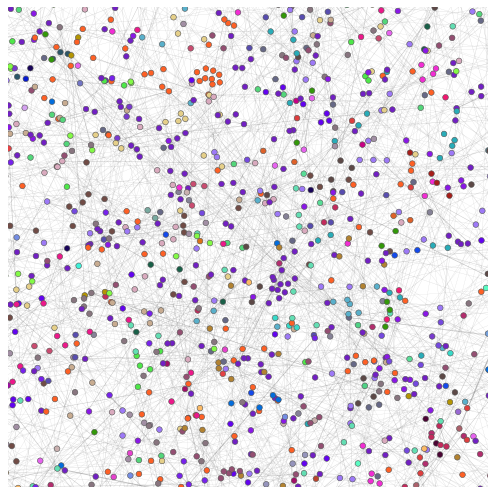

In [32]:
nx.set_node_attributes(G_thr, clusters, 'group')

visualize(G_thr, verbose=False, is_test = True)

Ex. 10.2.6: